# A. Libraries

In [143]:
!pip install findspark
!pip install nltk
!pip install -U deep-translator
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2022-04-30 16:06:02--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-04-30 16:06:02--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-04-30 16:06:03--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:44

In [144]:
import copy
import findspark
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import re
import sparknlp
import string

from collections import Counter

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, precision_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.svm import SVC

from sparknlp.annotator import *
from sparknlp.common import *
from sparknlp.base import *
from sparknlp.pretrained import ResourceDownloader

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [145]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# B. Dataset

In [146]:
column = ['tweet', 'sentiment']

In [147]:
def get_data(link):
    # read file from given link
    temp = pd.read_json(link, orient = "index")

    # remove unnecessary column
    temp = temp[column]

    # drop rows with null values
    temp = temp.dropna()

    # typecast sentiment as int (by default it is float)
    temp['sentiment'] = temp['sentiment'].astype(int)

    # select only data with sentiment = 1 or -1
    temp = temp.loc[(temp['sentiment'] == 1) | (temp['sentiment'] == -1)]
    temp.reset_index(drop = True, inplace = True)

    return temp

In [148]:
df = get_data("https://raw.githubusercontent.com/VinsenN/Sentiment-Analysis-Pemindahan-Ibu-Kota/main/data/IKN.json")
df.head()

,tweet,sentiment
0,"@jokowi saya sangat setuju pak, bahkan lebih s...",1
1,@hnurwahid @FPKSDPRRI Saya setuju ibu kota pin...,1
2,@MardaniAliSera @FPKSDPRRI Saya dan mayoritas ...,1
3,cocok ibu kota pindah ke kalimantan apalagi gu...,1
4,"@geedeulbeyou1 Jadi, kepada lo yang gak setuju...",1


<Figure size 1440x1080 with 0 Axes>

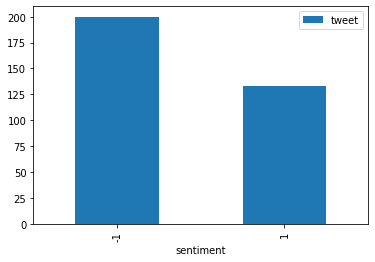

In [149]:
fig = plt.figure(figsize = (20, 15))
df.groupby('sentiment').count().plot.bar()

# C. Preprocess - Basic

In [150]:
# harga     emas      -> harga emas
def remove_redundant_space(text):
    # trailing spaces
    text = re.sub(" +$", "", text)
    # leading spaces
    text = re.sub("^ +", "", text)
    # redundant spaces
    text = re.sub(" +", " ", text)
    return text

In [151]:
def remove_mention(text):
    return re.sub("@\S+", " ", text)

In [152]:
def remove_hashtag(text):
    return re.sub("#\S+", " ", text)

In [153]:
# emojis, dll
def remove_special_char(text):
    return re.sub(r"[^a-zA-z0-9.,!?/:;\"\'\s]" , " ", text)

In [154]:
def remove_num(text):
    return re.sub(r"\d+", " ", text)

In [155]:
# hello! -> hello
def remove_punctuation(text):
    text = re.sub("_", " ", text)
    text = re.sub("_+", " ", text)
    text = re.sub(r"[^\w\s]", " ", text)
    return text;

In [156]:
def preprocess_basic(text):
    text = remove_mention(text)
    text = remove_hashtag(text)
    text = remove_special_char(text)
    text = remove_punctuation(text)
    text = remove_num(text)
    text = text.lower()
    text = remove_redundant_space(text)
    return text

In [157]:
testing_text = "       !\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~ HALO   🤣   Halo123 Halo     123 halo 😪😪😪😪 (Test) #IKN #Ibu_Kota_Negara @Vinsen_Nawir @Emmanuel_Henry     "
print(preprocess_basic(testing_text))

halo halo halo halo test


# D. Preprocess - More

### Remove insignificant words

We define insignificant words as the word that has less occurence than a predefined threshold.

In [158]:
def remove_noise(text: str, 
                 freq: Counter, 
                 threshold: int):
    
    text = " ".join([word for word in text.split()
                     if freq[word] >= threshold])
    return remove_redundant_space(text)

### Remove slangs and abbreviations

In [159]:
dict1 = pd.read_csv("https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv", encoding = "ISO-8859-1")
dict2 = pd.read_csv("https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv")
dict3 = pd.read_csv("https://raw.githubusercontent.com/VinsenN/Sentiment-Analysis-Pemindahan-Ibu-Kota/main/data/slang/custom-slang.csv")

In [160]:
columns = ['slang', 'formal']
dict1.columns = columns
dict2 = dict2[columns]
dict3.columns = columns

# Combine all dictionaries
dict1 = dict1.append(dict2)
dict1 = dict1.append(dict3)

# Remove duplicate values
dict1.sort_values('slang', inplace = True)
dict1.drop_duplicates(subset = columns, keep = False, inplace = True)

# Convert into python dict
kata_gaul = pd.Series(dict1['formal'].values, index = dict1['slang']).to_dict()

In [161]:
def normalize_slang(text):
    return " ".join([kata_gaul[word] if word in kata_gaul
                     else word
                     for word in text.split(' ')])

### Remove stopwords

In [162]:
# Creating stopword dictionary
stopword_list = stopwords.words('indonesian')
whitelist = ['tidak', 'bukan', 'enggak', 'daripada', 'melainkan']
blacklist = ['jokowi', 'joko', 'widodo', 'ahok', 'rocky', 'gerung', 'pks', 'partai', 'keadilan', 'sejahtera', 'oligarki', 'kalimantan', 'jawa', 'jakarta', 'jkt', 'papua']

for word in whitelist:
    stopword_list.remove(word)

for word in blacklist:
    stopword_list.append(word)

In [163]:
def remove_stopword(text):
    text = ' '.join([word if word not in stopword_list
                     else ""
                     for word in text.split(' ')])
    return remove_redundant_space(text)

In [164]:
testing_text = "sebagai presiden indonesia saya tidak setuju dengan pernyataan anda"
print(remove_stopword(testing_text))

presiden indonesia tidak setuju pernyataan


### Lemmatization

In [165]:
findspark.init()
spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  3.4.3
Apache Spark version:  3.0.3


In [166]:
# Create pipeline according to demo as shown below
# https://nlp.johnsnowlabs.com/2022/03/31/lemma_csui_id_3_0.html

document = DocumentAssembler().setInputCol("text").setOutputCol("document")
sentence = SentenceDetectorDLModel.pretrained("sentence_detector_dl", "xx").setInputCols(["document"]).setOutputCol("sentence")
tokenizer = Tokenizer().setInputCols(["sentence"]).setOutputCol("token")
lemma = LemmatizerModel.pretrained("lemma_csui", "id").setInputCols(["sentence", "token"]).setOutputCol("lemma")
pipeline = Pipeline(stages=[document, sentence, tokenizer, lemma])

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
lemma_csui download started this may take some time.
Approximate size to download 85.5 KB
[OK!]


In [167]:
def lemmatize(txt):
    data = spark.createDataFrame([[txt]]).toDF("text")
    result = pipeline.fit(data).transform(data)

    lemma_stc = []
    for x in result.head().lemma[1:]:
        lemma_stc.append(x.result)
    return (" ".join(lemma_stc))

In [168]:
testing_text = "presiden indonesia joko widodo melakukan pengesahan persetujuan pernyataan pemindahan ibu kota negara"
print(lemmatize(testing_text))

presiden indonesia joko widodo laku pengesahan setuju pernyataan pemindahan ibu kota negara


### Combining all preprocessing methods

In [169]:
def preprocess_advanced(text: str,
                        freq: Counter,
                        threshold: int):
    text = remove_noise(text, freq, threshold)
    text = normalize_slang(text)
    text = remove_stopword(text)
    text = lemmatize(text)
    return text

In [170]:
def count_frequency(data: pd.DataFrame):
        # generate word frequency table
        word_list = []
        for tweet in data['tweet']:
            for word in tweet.split():
                word_list.append(word)
        
        return Counter(word_list)

In [171]:
def preprocess(data: pd.DataFrame, threshold: int):
    clean = copy.deepcopy(data)
    counter = count_frequency(clean)
    clean['tweet'] = clean['tweet'].apply(preprocess_basic)
    clean['tweet'] = clean['tweet'].apply(preprocess_advanced, args =  (counter, threshold))
    return clean

# E. Model Creation

In [172]:
def get_w2v_arr(tokenized_x, **kwargs):
    w2v_model = Word2Vec(
                    tokenized_x, 
                    size = kwargs['size'], 
                    min_count = kwargs['min_count'], 
                    window = kwargs['window'], 
                    workers = 4, 
                    sg = 1, 
                    alpha = 0.01, 
                    min_alpha = 0.0001, 
                    seed = 777
                )

    res = np.zeros((len(tokenized_x), kwargs['size']))
    for i in range(len(tokenized_x)):
        for word in tokenized_x[i]:
            try:
                res[i] += w2v_model[word]
            except KeyError:
                continue

    if kwargs['scaling'] == 1:
        res = MinMaxScaler().fit_transform(res)
    return res

In [173]:
def get_d2v_arr(tokenized_x, **kwargs):
    d2v_model = Doc2Vec(
                    size = kwargs['size'], 
                    alpha = kwargs['alpha'], 
                    min_alpha = 0.00025, 
                    min_count = 1, 
                    dm = 1
                )
    d2v_model.build_vocab(tokenized_x)

    for epoch in range(kwargs['max_epochs']):
        d2v_model.train(tokenized_x, total_examples = d2v_model.corpus_count, epochs=d2v_model.iter)
        d2v_model.alpha -= 0.0002 # decrease the learning rate
        d2v_model.min_alpha = d2v_model.alpha # fix the learning rate, no decay
    
    res = np.zeros((len(tokenized_x), kwargs['size']))
    for i in range(len(tokenized_x)):
        res[i] = d2v_model.docvecs[i]
    
    if kwargs['scaling'] == 1:
        res = MinMaxScaler().fit_transform(x_d2v)
    return res

In [174]:
class SKLearn_Model:
    def __init__(self, 
                 data: pd.DataFrame, 
                 split: float, 
                 feature: str, 
                 model_type: str, 
                 **kwargs):
        
        # initialize parameter
        self.data = data
        self.split = split
        self.feature = feature
        self.model_type = model_type
        self.kwargs = kwargs
       
        # separate features and label
        self.x = self.data['tweet']
        self.y = self.data['sentiment']

        # feature extraction
        self.x_train, self.x_test, self.y_train, self.y_test = self._create_feature()

        # create model
        self._train_model()
    
    def _create_feature(self):
        x = self.x
        y = self.y

        if self.feature == "tf-idf":
            x_train, x_test, y_train, y_test = train_test_split(
                                                    x, y, 
                                                    test_size = self.split,
                                                    random_state = 777, # lucky number
                                                    stratify = y
                                               )

            tfidf = TfidfTransformer()
            count_vect = CountVectorizer()
            x_train_word_counts = count_vect.fit_transform(x_train)
            x_train = tfidf.fit_transform(x_train_word_counts)
            x_test = count_vect.transform(x_test)


        elif self.feature == "w2v":
            w2v_param = {
                'size': 300,
                'min_count': 2,
                'window': 1,
                'scaling': 0
            }

            if 'w2v_param' in self.kwargs:
                w2v_param = self.kwargs['w2v_param']

            x_token = x.apply(lambda x: x.split())
            x_token = x_token.reset_index(drop = True)

            w2v_x = get_w2v_arr(x_token, **w2v_param)

            x_train, x_test, y_train, y_test = train_test_split(
                                                    w2v_x, y, 
                                                    test_size = self.split,
                                                    random_state = 777, # lucky number
                                                    stratify = y
                                               )
        
        elif self.feature == "d2v":
            d2v_param = {
                'size': 200,
                'max_epochs': 50,
                'alpha': 0.025,
                'scaling': 0
            }

            if 'd2v_param' in self.kwargs:
                w2v_param = self.kwargs['w2v_param']
            
            x_tag_token = [TaggedDocument(words=word_tokenize(w), tags=[str(i)]) for i, w in enumerate(x)]
            d2v_x = get_d2v_arr(x_tag_token, **d2v_param)

            x_train, x_test, y_train, y_test = train_test_split(
                                                    d2v_x, y, 
                                                    test_size = self.split,
                                                    random_state = 777, # lucky number
                                                    stratify = y
                                               )     

        return [x_train, x_test, y_train, y_test]

    def _train_model(self):
        if self.model_type == "mnb":
            # set default grid search parameter
            self.mnb_param = {
                'alpha': [0.0001, 0.01, 1.0],
                'fit_prior': [True, False],
            }
            # if custom parameter exists, use it instead
            if 'mnb_param' in self.kwargs:
                self.mnb_param = self.kwargs['mnb_param']
            
            mnb = MultinomialNB().fit(self.x_train, self.y_train)
            mnb_grid = GridSearchCV(mnb, param_grid = self.mnb_param, scoring = "accuracy", n_jobs = -1)

            %time mnb_grid.fit(self.x_train, self.y_train)
            self.best_params = mnb_grid.best_params_

            self.model = MultinomialNB(**self.best_params)
            self.model.fit(self.x_train, self.y_train)

        elif self.model_type == "svm":
            # set default grid search parameter
            self.svm_param = {
                'C': [0.01, 0.1, 1, 10, 100],
                'kernel': ["linear", "rbf"],
                'gamma': [0.001, 0.01, 0.1, 1, 10, 'auto']
            }
            # if custom parameter exists, use it instead
            if 'svm_param' in self.kwargs:
                self.svm_param = self.kwargs['svm_param']

            svm = SVC().fit(self.x_train, self.y_train)
            svm_grid = GridSearchCV(svm, param_grid = self.svm_param, scoring = "accuracy", n_jobs = -1)

            %time svm_grid.fit(self.x_train, self.y_train)
            self.best_params = svm_grid.best_params_

            self.model = SVC(**self.best_params)
            self.model.fit(self.x_train, self.y_train)
    
    def evaluate_model(self):
        print("\nBest Parameter")
        print("=====================================================")
        print(self.best_params)
        
        y_pred = self.model.predict(self.x_train)
        print("\nTraining Dataset")
        print("=====================================================")
        print(f"accuracy score  : {accuracy_score(self.y_train, y_pred) * 100}")
        print(f"precision score : {precision_score(self.y_train, y_pred, average = 'macro') * 100}")
        print(f"recall score    : {recall_score(self.y_train, y_pred, average = 'macro') * 100}")
        print(f"f1-score        : {f1_score(self.y_train, y_pred, average = 'macro') * 100}")

        y_pred = self.model.predict(self.x_test)
        print("\nTesting Dataset")
        print("=====================================================")
        plot_confusion_matrix(self.model, self.x_test, self.y_test)
        print(f"accuracy score  : {accuracy_score(self.y_test, y_pred) * 100}")
        print(f"precision score : {precision_score(self.y_test, y_pred, average = 'macro') * 100}")
        print(f"recall score    : {recall_score(self.y_test, y_pred, average = 'macro') * 100}")
        print(f"f1-score        : {f1_score(self.y_test, y_pred, average = 'macro') * 100}")
        print("\n")

# F. Evaluation

In [175]:
dataset = preprocess(df, 5)
dataset_10 = preprocess(df, 10)

### MNB with TF-IDF


CPU times: user 145 ms, sys: 33.7 ms, total: 179 ms
Wall time: 1.91 s

Best Parameter
{'alpha': 1.0, 'fit_prior': True}

Training Dataset
accuracy score  : 78.57142857142857
precision score : 77.7928990503841
recall score    : 77.09316037735849
f1-score        : 77.38196464533453

Testing Dataset
accuracy score  : 80.59701492537313
precision score : 80.74866310160428
recall score    : 81.94444444444444
f1-score        : 80.44015270604086




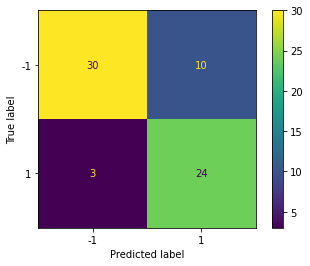

In [176]:
model = SKLearn_Model(dataset, 0.2, "tf-idf", "mnb")
model.evaluate_model()

CPU times: user 72.3 ms, sys: 1.19 ms, total: 73.5 ms
Wall time: 131 ms

Best Parameter
{'alpha': 1.0, 'fit_prior': False}

Training Dataset
accuracy score  : 77.6824034334764
precision score : 78.82558312286436
recall score    : 79.80414746543778
f1-score        : 77.61271249076127

Testing Dataset
accuracy score  : 81.0
precision score : 81.2124849939976
recall score    : 82.5
f1-score        : 80.84484323016434




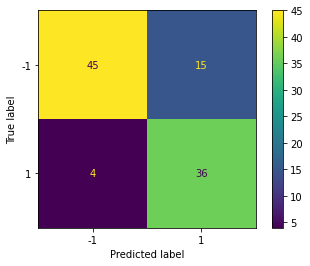

In [177]:
model = SKLearn_Model(dataset, 0.3, "tf-idf", "mnb")
model.evaluate_model()

CPU times: user 66.3 ms, sys: 2.04 ms, total: 68.3 ms
Wall time: 110 ms

Best Parameter
{'alpha': 0.0001, 'fit_prior': False}

Training Dataset
accuracy score  : 77.44360902255639
precision score : 78.47791438979964
recall score    : 79.49882075471699
f1-score        : 77.36170212765958

Testing Dataset
accuracy score  : 77.61194029850746
precision score : 82.14285714285714
recall score    : 81.25
f1-score        : 77.59197324414716




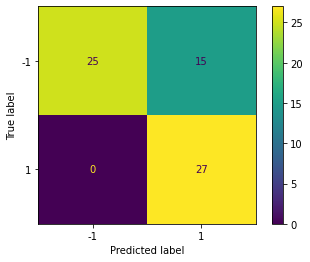

In [178]:
model = SKLearn_Model(dataset_10, 0.2, "tf-idf", "mnb")
model.evaluate_model()

CPU times: user 71.4 ms, sys: 4.74 ms, total: 76.1 ms
Wall time: 135 ms

Best Parameter
{'alpha': 0.0001, 'fit_prior': False}

Training Dataset
accuracy score  : 77.25321888412017
precision score : 78.52678571428571
recall score    : 79.44700460829492
f1-score        : 77.19272324314342

Testing Dataset
accuracy score  : 77.0
precision score : 78.96776825785395
recall score    : 79.58333333333334
f1-score        : 76.9792813532179




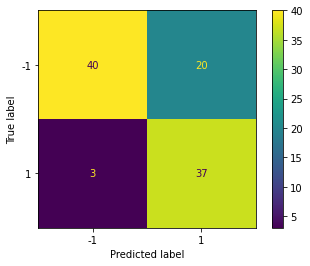

In [179]:
model = SKLearn_Model(dataset_10, 0.3, "tf-idf", "mnb")
model.evaluate_model()

### SVM with TF-IDF

CPU times: user 481 ms, sys: 7.78 ms, total: 489 ms
Wall time: 1.88 s

Best Parameter
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 95.86466165413535
precision score : 95.51510547536961
recall score    : 95.92570754716981
f1-score        : 95.70684469224562

Testing Dataset
accuracy score  : 61.19402985074627
precision score : 58.4045584045584
recall score    : 55.46296296296296
f1-score        : 53.670212765957444




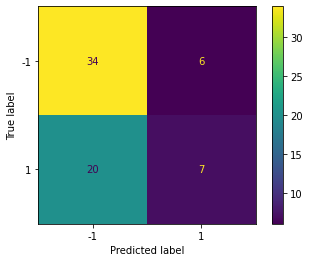

In [180]:
model = SKLearn_Model(dataset, 0.2, "tf-idf", "svm")
model.evaluate_model()

CPU times: user 502 ms, sys: 4.96 ms, total: 507 ms
Wall time: 1.67 s

Best Parameter
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 95.70815450643777
precision score : 96.11084868524642
recall score    : 94.98463901689709
f1-score        : 95.47397047397048

Testing Dataset
accuracy score  : 56.99999999999999
precision score : 46.336996336996336
recall score    : 48.75
f1-score        : 41.88403838356535




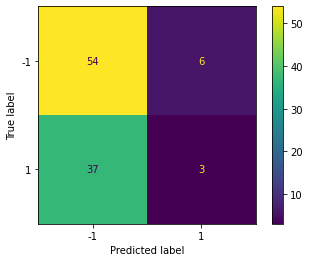

In [181]:
model = SKLearn_Model(dataset, 0.3, "tf-idf", "svm")
model.evaluate_model()

CPU times: user 486 ms, sys: 12.2 ms, total: 498 ms
Wall time: 1.63 s

Best Parameter
{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 94.3609022556391
precision score : 93.88259226968904
recall score    : 94.51650943396226
f1-score        : 94.16282642089094

Testing Dataset
accuracy score  : 61.19402985074627
precision score : 58.52272727272727
recall score    : 54.861111111111114
f1-score        : 52.247807017543856




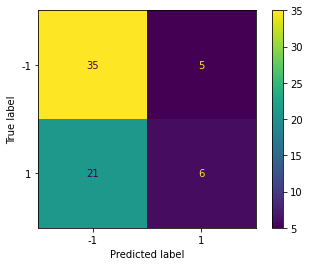

In [182]:
model = SKLearn_Model(dataset_10, 0.2, "tf-idf", "svm")
model.evaluate_model()

CPU times: user 458 ms, sys: 17 ms, total: 475 ms
Wall time: 1.45 s

Best Parameter
{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

Training Dataset
accuracy score  : 84.12017167381974
precision score : 83.38197874569676
recall score    : 84.25883256528418
f1-score        : 83.68625224713786

Testing Dataset
accuracy score  : 69.0
precision score : 76.64796633941093
recall score    : 73.75
f1-score        : 68.74684948079444




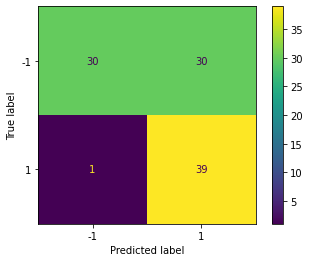

In [183]:
model = SKLearn_Model(dataset_10, 0.3, "tf-idf", "svm")
model.evaluate_model()

### SVM with Word2Vec

CPU times: user 509 ms, sys: 28.1 ms, total: 537 ms
Wall time: 2.46 s

Best Parameter
{'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 83.0827067669173
precision score : 82.8071068862106
recall score    : 84.18632075471699
f1-score        : 82.84977433913603

Testing Dataset
accuracy score  : 76.11940298507463
precision score : 77.43243243243244
recall score    : 78.19444444444444
f1-score        : 76.07142857142857




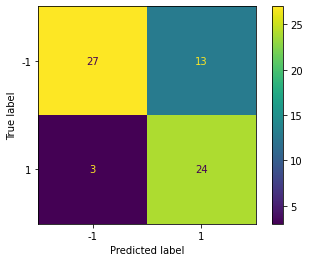

In [184]:
model = SKLearn_Model(dataset, 0.2, "w2v", "svm")
model.evaluate_model()

CPU times: user 813 ms, sys: 38.1 ms, total: 851 ms
Wall time: 2.38 s

Best Parameter
{'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 83.69098712446352
precision score : 83.41814159292036
recall score    : 84.80414746543778
f1-score        : 83.46900672143391

Testing Dataset
accuracy score  : 77.0
precision score : 76.81072428971589
recall score    : 77.91666666666666
f1-score        : 76.7182913250329




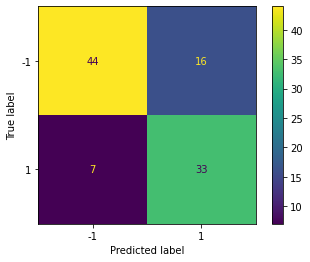

In [185]:
model = SKLearn_Model(dataset, 0.3, "w2v", "svm")
model.evaluate_model()

CPU times: user 558 ms, sys: 48 ms, total: 606 ms
Wall time: 2.63 s

Best Parameter
{'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 79.69924812030075
precision score : 80.31746031746032
recall score    : 81.53301886792453
f1-score        : 79.58383080334299

Testing Dataset
accuracy score  : 79.1044776119403
precision score : 81.54761904761905
recall score    : 81.89814814814815
f1-score        : 79.09982174688056




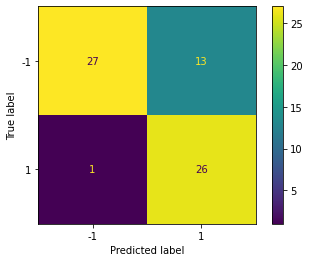

In [186]:
model = SKLearn_Model(dataset_10, 0.2, "w2v", "svm")
model.evaluate_model()

CPU times: user 509 ms, sys: 25.5 ms, total: 535 ms
Wall time: 2.04 s

Best Parameter
{'C': 100, 'gamma': 10, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 80.25751072961373
precision score : 80.91648189209164
recall score    : 82.12749615975422
f1-score        : 80.15185185185184

Testing Dataset
accuracy score  : 78.0
precision score : 78.44551282051282
recall score    : 79.58333333333334
f1-score        : 77.85829307568439




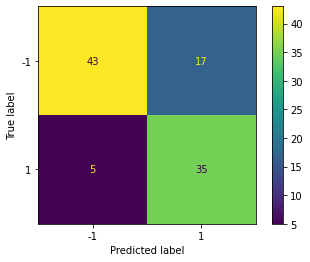

In [187]:
model = SKLearn_Model(dataset_10, 0.3, "w2v", "svm")
model.evaluate_model()

### SVM with Doc2Vec

CPU times: user 529 ms, sys: 15.8 ms, total: 545 ms
Wall time: 3.44 s

Best Parameter
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 85.71428571428571
precision score : 84.98850574712644
recall score    : 85.89622641509433
f1-score        : 85.31240918337693

Testing Dataset
accuracy score  : 77.61194029850746
precision score : 76.8918918918919
recall score    : 77.63888888888889
f1-score        : 77.10184552289815




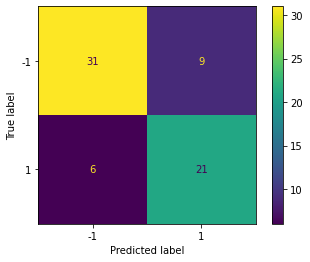

In [188]:
model = SKLearn_Model(dataset, 0.2, "d2v", "svm")
model.evaluate_model()

CPU times: user 488 ms, sys: 13.4 ms, total: 502 ms
Wall time: 3.07 s

Best Parameter
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

Training Dataset
accuracy score  : 84.97854077253218
precision score : 84.34853662160155
recall score    : 85.51459293394778
f1-score        : 84.6517230346489

Testing Dataset
accuracy score  : 78.0
precision score : 77.0935960591133
recall score    : 77.5
f1-score        : 77.26333195535344




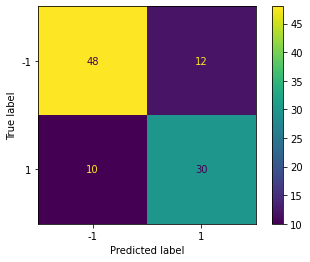

In [189]:
model = SKLearn_Model(dataset, 0.3, "d2v", "svm")
model.evaluate_model()

CPU times: user 477 ms, sys: 19.2 ms, total: 496 ms
Wall time: 2.08 s

Best Parameter
{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}

Training Dataset
accuracy score  : 81.203007518797
precision score : 81.1284486657621
recall score    : 82.46462264150944
f1-score        : 80.99239695878352

Testing Dataset
accuracy score  : 85.07462686567165
precision score : 84.93761140819964
recall score    : 86.29629629629629
f1-score        : 84.90990990990991




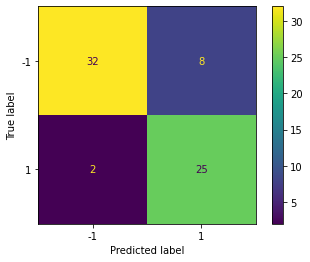

In [190]:
model = SKLearn_Model(dataset_10, 0.2, "d2v", "svm")
model.evaluate_model()

CPU times: user 490 ms, sys: 11.9 ms, total: 502 ms
Wall time: 1.79 s

Best Parameter
{'C': 100, 'gamma': 0.001, 'kernel': 'linear'}

Training Dataset
accuracy score  : 81.97424892703863
precision score : 81.56845369960124
recall score    : 82.83410138248848
f1-score        : 81.69061517736867

Testing Dataset
accuracy score  : 83.0
precision score : 82.23174214606284
recall score    : 82.91666666666666
f1-score        : 82.49407887962104




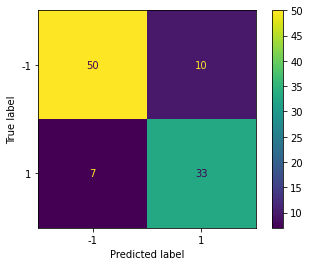

In [191]:
model = SKLearn_Model(dataset_10, 0.3, "d2v", "svm")
model.evaluate_model()

CPU times: user 518 ms, sys: 12.6 ms, total: 530 ms
Wall time: 3.11 s

Best Parameter
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Training Dataset
accuracy score  : 98.1203007518797
precision score : 97.96920002351143
recall score    : 98.1191037735849
f1-score        : 98.04259202025108

Testing Dataset
accuracy score  : 67.16417910447761
precision score : 66.1524500907441
recall score    : 66.48148148148148
f1-score        : 66.25457875457876




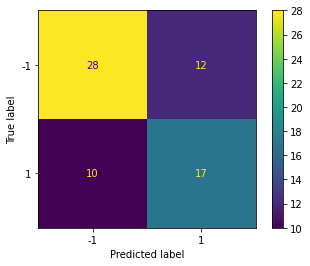

In [192]:
mod = SKLearn_Model(df, 0.2, "d2v", "svm")
mod.evaluate_model()